loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


c:\Users\pcsal\miniforge3\envs\py_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pcsal\miniforge3\envs\py_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\pcsal\AppData\Local\Temp\ipykernel_2896\520695332.py:140: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  opt, scaler = torch.optim.AdamW(model.parameters(), lr=args.lr), GradScaler()
C:\Users\pcsal\AppData\Lo

  [ 10% ] Training Loss: 0.9281
  [ 20% ] Training Loss: 0.7829
  [ 30% ] Training Loss: 0.6974
  [ 40% ] Training Loss: 0.9610
  [ 50% ] Training Loss: 0.9791
  [ 60% ] Training Loss: 0.8645
  [ 70% ] Training Loss: 0.7421
  [ 79% ] Training Loss: 0.9311
  [ 89% ] Training Loss: 1.2350
  [ 99% ] Training Loss: 0.8342
  [ 100% ] Training Loss: 0.7227


C:\Users\pcsal\AppData\Local\Temp\ipykernel_2896\520695332.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  [ 10% ] Validating...
  [ 20% ] Validating...
  [ 29% ] Validating...
  [ 39% ] Validating...
  [ 49% ] Validating...
  [ 59% ] Validating...
  [ 68% ] Validating...
  [ 78% ] Validating...
  [ 88% ] Validating...
  [ 98% ] Validating...
  [ 100% ] Validating...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.83s).
Accumulating evaluation results...
DONE (t=0.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 |

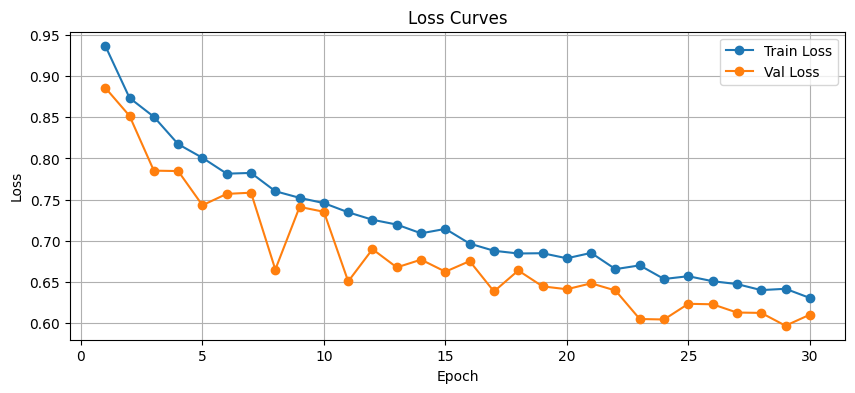

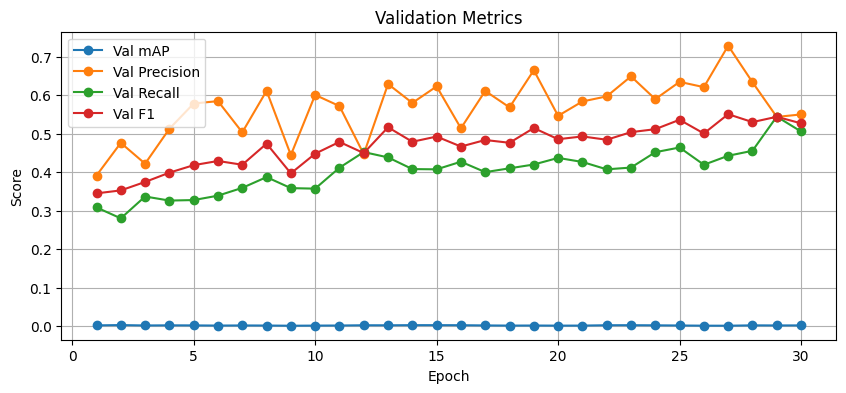

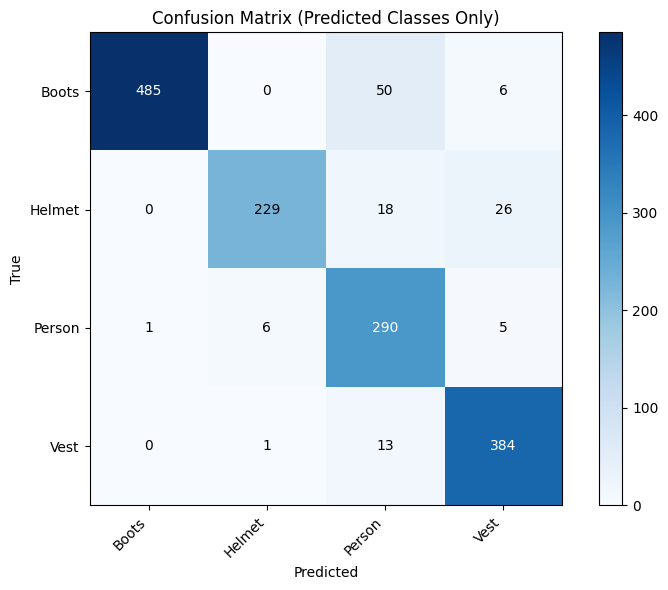

In [65]:
import sys, argparse
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix

# speed-ups
torch.backends.cudnn.benchmark = True

def collate_fn(batch):
    return tuple(zip(*batch))

def get_detection_loaders(root: Path, bs: int, workers: int):
    from torchvision.transforms import ColorJitter, RandomRotation

    splits = ['train', 'valid', 'test']
    loaders, coco_gt = {}, None

    for sp in splits:
        img_dir = root / sp
        ann_file = img_dir / '_annotations.coco.json'
        if sp == 'train':
            tfms = transforms.Compose([
                transforms.RandomResizedCrop((640,640)),
                transforms.RandomHorizontalFlip(),
                ColorJitter(0.3,0.3,0.3),
                RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
        else:
            tfms = transforms.Compose([
                transforms.Resize((640,640)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])

        ds = CocoDetection(str(img_dir), str(ann_file), transform=tfms)
        loaders[sp] = DataLoader(ds,
                                batch_size=bs,
                                shuffle=(sp=='train'),
                                num_workers=workers,
                                pin_memory=True,
                                collate_fn=collate_fn)
        if sp == 'train':
            coco_gt = COCO(str(ann_file))

    cats = coco_gt.loadCats(coco_gt.getCatIds())
    class_names = {c['id']: c['name'] for c in cats}
    return loaders['train'], loaders['valid'], loaders['test'], coco_gt, class_names

def build_model(num_classes: int):
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_f = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_f, num_classes)
    # fewer proposals for speed
    model.rpn.pre_nms_top_n_train = 2000
    model.rpn.pre_nms_top_n_test  = 1000
    model.rpn.post_nms_top_n_train= 2000
    model.rpn.post_nms_top_n_test = 1000
    return model

def evaluate_coco(model, loader, coco_gt, device):
    model.eval()
    results = []
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [i.to(device) for i in imgs]
            outs = model(imgs)
            for t,o in zip(targets, outs):
                img_id = int(t[0]['image_id']) if len(t) else -1
                for box,score,label in zip(o['boxes'],o['scores'],o['labels']):
                    b = box.detach().cpu().numpy().tolist()
                    b = [b[0],b[1],b[2]-b[0],b[3]-b[1]]
                    results.append({
                        'image_id':img_id,
                        'category_id':int(label.item()),
                        'bbox':b,
                        'score':float(score.item())
                    })
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate(); coco_eval.accumulate(); coco_eval.summarize()
    return coco_eval.stats[0]

def evaluate_prf(model, loader, device, iou_thresh=0.5, score_thresh=0.5):
    model.eval()
    tp=fp=fn=0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [i.to(device) for i in imgs]
            outs = model(imgs)
            for t,o in zip(targets, outs):
                if not t:
                    gt_boxes = torch.zeros((0,4), device=device)
                    gt_labels= torch.zeros((0,), dtype=torch.int64, device=device)
                else:
                    b = torch.tensor([ann['bbox'] for ann in t], dtype=torch.float32, device=device)
                    b[:,2:] += b[:,:2]; gt_boxes=b
                    gt_labels = torch.tensor([ann['category_id'] for ann in t], dtype=torch.int64, device=device)
                pb,pl,ps = o['boxes'].detach().to(device), o['labels'].detach().to(device), o['scores'].detach().to(device)
                keep = ps>=score_thresh; pb,pl=pb[keep],pl[keep]
                used = torch.zeros(len(pb), dtype=torch.bool, device=device)
                for gb,gl in zip(gt_boxes, gt_labels):
                    if not pb.numel(): fn+=1; continue
                    same = pl==gl
                    if not same.any(): fn+=1; continue
                    ious = box_iou(gb.unsqueeze(0), pb[same])[0]
                    max_i,idx = ious.max(0)
                    if max_i>=iou_thresh:
                        idxs=torch.nonzero(same).squeeze(1); pi=idxs[idx]
                        if not used[pi]: tp+=1; used[pi]=True
                        else: fp+=1
                    else: fn+=1
                fp += (~used).sum().item()
    prec = tp/(tp+fp) if tp+fp>0 else 0.0
    rec  = tp/(tp+fn) if tp+fn>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if prec+rec>0 else 0.0
    return prec, rec, f1

def main(args):
    root = Path(args.data_dir)/args.zip_name.replace('.zip','')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dl,val_dl,test_dl,coco_gt,class_names = get_detection_loaders(
        root, args.batch_size, args.workers)
    model = build_model(len(class_names)+1).to(device)
    opt, scaler = torch.optim.AdamW(model.parameters(), lr=args.lr), GradScaler()

    train_losses, val_losses = [], []
    val_mAPs, val_P, val_R, val_F1 = [], [], [], []

    for ep in range(1, args.epochs+1):
        # ─── Train ─────────────────────────────────────────
        model.train()
        total_loss, tb = 0.0, len(train_dl)
        interval = max(1, tb//10)
        for bidx,(imgs,targets) in enumerate(train_dl,1):
            imgs = [i.to(device) for i in imgs]
            newt = []
            for t in targets:
                if not t:
                    newt.append({'boxes':torch.zeros((0,4),device=device),
                                 'labels':torch.zeros((0,),device=device,dtype=torch.int64)})
                else:
                    b = torch.tensor([ann['bbox'] for ann in t], dtype=torch.float32, device=device)
                    b[:,2:] += b[:,:2]
                    l = torch.tensor([ann['category_id'] for ann in t], dtype=torch.int64, device=device)
                    newt.append({'boxes':b,'labels':l})

            with autocast():
                ld = model(imgs, newt)
                loss = sum(ld.values())

            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            total_loss += loss.item()
            if bidx%interval==0 or bidx==tb:
                pct = bidx/tb*100
                print(f"  [ {pct:.0f}% ] Training Loss: {loss.item():.4f}")

        train_losses.append(total_loss/tb)

        # ─── Validate (compute loss in train mode) ─────────
        model.train()
        vloss, vt = 0.0, len(val_dl)
        v_int = max(1, vt//10)
        with torch.no_grad():
            for vidx,(imgs,targets) in enumerate(val_dl,1):
                imgs = [i.to(device) for i in imgs]
                newt=[]
                for t in targets:
                    if not t:
                        newt.append({'boxes':torch.zeros((0,4),device=device),
                                     'labels':torch.zeros((0,),device=device,dtype=torch.int64)})
                    else:
                        b=torch.tensor([ann['bbox'] for ann in t],dtype=torch.float32,device=device)
                        b[:,2:] += b[:,:2]
                        l=torch.tensor([ann['category_id'] for ann in t],dtype=torch.int64,device=device)
                        newt.append({'boxes':b,'labels':l})
                with autocast():
                    ld = model(imgs, newt)
                vloss += sum(ld.values()).item()
                if vidx%v_int==0 or vidx==vt:
                    vpct = vidx/vt*100
                    print(f"  [ {vpct:.0f}% ] Validating...")

        val_losses.append(vloss/vt)

        # ─── Metrics ─────────────────────────────────────────
        mAP = evaluate_coco(model, val_dl, coco_gt, device)
        P, R, F1 = evaluate_prf(model, val_dl, device)
        val_mAPs.append(mAP); val_P.append(P); val_R.append(R); val_F1.append(F1)

        print(f"Epoch {ep}/{args.epochs} ➤ TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}, "
              f"mAP={mAP:.4f}, P={P:.4f}, R={R:.4f}, F1={F1:.4f}\n")

    # ─── Plot Loss & Metrics ───────────────────────────────────
    epochs = range(1, args.epochs+1)
    plt.figure(figsize=(10,4))
    plt.plot(epochs, train_losses, '-o', label='Train Loss')
    plt.plot(epochs, val_losses,   '-o', label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curves')
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(epochs, val_mAPs, '-o', label='Val mAP')
    plt.plot(epochs, val_P,    '-o', label='Val Precision')
    plt.plot(epochs, val_R,    '-o', label='Val Recall')
    plt.plot(epochs, val_F1,   '-o', label='Val F1')
    plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Validation Metrics')
    plt.legend(); plt.grid(True); plt.show()

    # ─── Confusion Matrix (predicted classes only) ────────
    y_true, y_pred, seen = [], [], set()
    model.eval()
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs = [i.to(device) for i in imgs]
            for t,o in zip(targets, model(imgs)):
                if not t: continue
                gt_b = torch.tensor([ann['bbox'] for ann in t], dtype=torch.float32, device=device)
                gt_b[:,2:] += gt_b[:,:2]
                gt_l = torch.tensor([ann['category_id'] for ann in t], dtype=torch.int64, device=device)
                pb,pl = o['boxes'].detach().to(device), o['labels'].detach().to(device)

                if not pb.numel():
                    for gl in gt_l:
                        y_true.append(gl.item()); y_pred.append(gl.item()); seen.add(gl.item())
                else:
                    ious = box_iou(gt_b, pb)
                    for gi, gl in enumerate(gt_l):
                        _,pj = ious[gi].max(0)
                        yi, yp = gl.item(), pl[pj].item()
                        y_true.append(yi); y_pred.append(yp); seen.update([yi,yp])

    labels = sorted(seen)
    names  = [class_names[i] for i in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix (Predicted Classes Only)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.yticks(range(len(names)), names)
    thresh = cm.max()/2
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j]>thresh else 'black')
    plt.colorbar(); plt.tight_layout(); plt.show()

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir',   type=str,   default=r"C:\Users\pcsal\ECGR4106")
    parser.add_argument('--zip-name',   type=str,   default="PPE_Dataset.coco.zip")
    parser.add_argument('--batch-size', type=int,   default=4)
    parser.add_argument('--workers',    type=int,   default=0)
    parser.add_argument('--epochs',     type=int,   default=30)
    parser.add_argument('--lr',         type=float, default=1e-4)
    args = parser.parse_args()
    main(args)
